In [1]:
#loading the libraries
from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import rpy2
from scipy.stats import spearmanr,pearsonr
from CCIT import CCIT


2022-08-22 09:19:54.484605: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 09:19:54.484623: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#defining the class MDN
class MDN_module(tf.keras.Model):
#changed from 15 to 20
    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\", name="+"'h"+str(i)+"')"
          exec(s)
        #self.h1=Dense(12,activation="relu",name="h1")
        #self.h2=Dense(8,activation="relu",name="h2")
        #self.h3=Dense(8,activation="relu",name="h3")
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        x=self.h2(x)
        #x=self.h3(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [3]:
no_parameters=3
components=1
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    #print(alpha)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    """ Evaluate the model to get the loss for the given x and y 
    """
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def eval_mdn_model_mle(x_test,y_test):
        indices_1 = [i for i, x in enumerate(x_test) if x == 1]
        #changing x to -1
        indices_0 = [i for i, x in enumerate(x_test) if x == 0]
        mu_0=np.mean(y_test[indices_0])
        mu_1=np.mean(y_test[indices_1])
        sigma_0=np.std(y_test[indices_0])
        sigma_1=np.std(y_test[indices_1])
        y_mean=np.zeros((len(y_test),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        y_std=np.zeros((len(y_test),1))
        y_std[indices_1]=sigma_1
        y_std[indices_0]=sigma_0
        alpha=np.ones((len(y_mean),1))
        return gnll_eval(y_test,alpha,y_mean,y_std).numpy()
    
def reshapevar(X):
  """
  Function to reshape the vector for the input 
  """
  return np.reshape(X,newshape=(len(X),-1))

In [4]:
def compute_loss(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        #return np.array(nlcor.nlcor(P,Q)[0])[0]
        return eval_mdn_model(P,Q,mdn_PQ)
    else:
        return eval_mdn_model_mle(P,Q)
        
        
        


In [5]:
def compute_loss_y_pred(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))
        return y_pred[:,1]
    else:
        indices_1 = [i for i, x in enumerate(P) if x == 1]
        indices_0 = [i for i, x in enumerate(P) if x == 0]
        mu_0=np.mean(Q[indices_0])
        mu_1=np.mean(Q[indices_1])
        #sigma_0=np.std(Q[indices_0])
        #sigma_1=np.std(Q[indices_1])
        y_mean=np.zeros((len(Q),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        return y_mean.reshape((len(y_mean),))
        

In [6]:
def shuffleBtimes(P,Q,B,mle=False):
    """ Shuffle Q B times and compute the loss 
    """
    loss=[]
    if(mle==False):
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q)))
    else:
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q),True))
    return loss


In [7]:
def LinearLABData():
    """ Generate the linear data 
    """
    L = np.random.binomial(1,0.5,1000)  
    beta0 = np.ones(1000)-0.4
    #beta1 = 0.5
    beta1=3
    beta2= 0.3
    beta3=0.8
    #eps0 = np.random.standard_normal(1000)
    #eps1 = np.random.standard_normal(1000)
    eps0 = np.random.normal(0,1,1000)
    eps1 = np.random.normal(0,1,1000)
    A = beta0 + beta1*L + eps0
    #B=beta2+beta3*np.sin(A)+eps1
    B = beta2+ beta3*A + eps1 
    plt.scatter(A,B)
    plt.title("A vs B")
    plt.xlabel("A")
    plt.ylabel("B")
    return [L,A,B]

In [8]:
yeast=open("../yeast_full_data/yeast_residual_data_full_62k_gt1.txt","r")



#yeast data read 
L=[]
A=[]
B=[]
for i in range(0,62296):
    line=yeast.readline()
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=yeast.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=yeast.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=yeast.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_0 = [i for i in zip(L,A,B)]


KeyboardInterrupt: 

In [ ]:
plt.scatter(dataset_0[2732][1],dataset_0[2732][2])

In [ ]:
L=np.array(dataset_0[2732][0])
A=np.array(dataset_0[2732][1])
B=np.array(dataset_0[2732][2])

In [ ]:
open("dataset_params.txt", "r")

In [9]:
fo=open("/home/aravind/projects/CIT_Non_Linear/LinearDifferentvalues/testing_writingvalues_Linear0to1.txt", "r")
L=[]
A=[]
B=[]
#fe=open("dataset_params.txt",'w')
for i in range(0,121):
    line=fo.readline()
    #fe.write(line)
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=fo.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=fo.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=fo.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_linear = [i for i in zip(L,A,B)]
fo.close()
#fe.close()

In [46]:
L=dataset_linear[2][0]
A=dataset_linear[2][1]
B=dataset_linear[2][2]

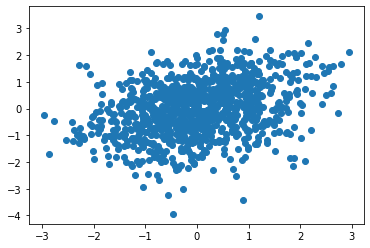

In [47]:
plt.scatter(A,B)

In [227]:
len(dataset_names)

121

In [ ]:
yeast=open("../yeast_full_data/yeast_residual_data_full_209k_gt2.txt","r")
L=[]
A=[]
B=[]
for i in range(0,209157):
    line=yeast.readline()
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=yeast.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=yeast.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=yeast.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_0 = [i for i in zip(L,A,B)]

In [ ]:
read_file = open("indicesUsedIndependent.pkl", "rb")
indices=pickle.load(read_file)
read_file.close()

In [ ]:
dataset_yeast10k_ind=[dataset_0[q] for q in indices]

In [ ]:
read_file = open("indicesUsedIndependent.pkl", "rb")
indices=pickle.load(read_file)
read_file.close()

In [ ]:
fo=open("./LinearDifferentvalues/testing_writingvalues_Indpendent.txt", "r")
L=[]
A=[]
B=[]
#fe=open("dataset_params.txt",'w')
for i in range(0,100):
    line=fo.readline()
    #fe.write(line)
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=fo.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=fo.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=fo.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_linear = [i for i in zip(L,A,B)]
fo.close()
#fe.close()

In [ ]:
import os
os.getcwd()

In [224]:
fer=open("LinearDifferentvalues/dataset_params_Linear0to1.txt","r")
dataset_names=[]
for i in range(0,121):
    line=fer.readline()
    line="_".join(line.split())
    dataset_names.append(line)
fer.close()

In [16]:
def calculate_pvalue(original,loss_list):
    '''
    calculate the p value 
    '''
    return sum(abs(i) < abs(original) for i in loss_list)/len(loss_list)
    
    

In [17]:
def compute_third_testloss(A,B):
    opt = tf.optimizers.Adam(1e-2)
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
##changing epochs didnt make much difference

#mdn_PQ.fit(x=C, y=np.array(B).T,epochs=300,  batch_size=64)
    withoutL=mdn_PQ.fit(x=A, y=B.T,epochs=100,  batch_size=64,verbose=0)
    y_pred = mdn_PQ.predict(A)
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(B).numpy()
    return -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [14]:
def calculate_difference(L,A,B):
    return compute_third_testloss(reshapevar(A),np.array(B))-compute_third_testloss(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1),np.array(B))
    

In [15]:
def stratify_B_n_times_diff(L,A,B,n):
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changing x== -1 
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    for i in range(0,n):
        B_dist_temp=np.zeros(len(B))
        mod_indices_1=random.sample(indices_1,len(indices_1))
        for i in range(len(indices_1)):
            B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

        mod_indices_0=random.sample(indices_0,len(indices_0))
        for i in range(len(indices_0)):
            B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
        loss.append(calculate_difference(L,A,B_dist_temp))
    return loss

In [141]:
def stratify_B_ntimes_permuteL(L,A,B,n, B_perm=False):
    loss=[]
    if(B_perm==True):
        indices_1 = [i for i, x in enumerate(L) if x == 1]
        #changing x== -1 
        indices_0 = [i for i, x in enumerate(L) if x == 0]
        B_dist_temp=np.zeros(len(B))
        mod_indices_1=random.sample(indices_1,len(indices_1))
        for i in range(len(indices_1)):
            B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

        mod_indices_0=random.sample(indices_0,len(indices_0))
        for i in range(len(indices_0)):
            B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
        opt = tf.optimizers.Nadam(1e-3)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        withoutL=mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B_dist_temp.T,epochs=100,  batch_size=32,verbose=0)
        y_pred = mdn_PQ.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))
        alpha,mu,sigma = slice_parameter_vectors(y_pred)
        gm = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=alpha),
                components_distribution=tfd.Normal(
                    loc=mu,       
                    scale=sigma))
        log_likelihood = gm.log_prob(B_dist_temp).numpy()
        loss_original= -tf.reduce_mean(log_likelihood, axis=-1).numpy()
        for j in range(n):
            L_shuffle=np.random.permutation(L)
            y_pred = mdn_PQ.predict(np.concatenate([L_shuffle.reshape(-1,1),A.reshape(-1,1)],axis=1))
            alpha,mu,sigma = slice_parameter_vectors(y_pred)
            gm = tfd.MixtureSameFamily(
                    mixture_distribution=tfd.Categorical(probs=alpha),
                    components_distribution=tfd.Normal(
                        loc=mu,       
                        scale=sigma))
            log_likelihood = gm.log_prob(B_dist_temp).numpy()
            loss_shuffle= -tf.reduce_mean(log_likelihood, axis=-1).numpy()
            loss.append(loss_shuffle-loss_original)
    else:
        opt = tf.optimizers.Nadam(1e-3)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        withoutL=mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B.T,epochs=100,  batch_size=32,verbose=0)
        y_pred = mdn_PQ.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))
        alpha,mu,sigma = slice_parameter_vectors(y_pred)
        gm = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=alpha),
                components_distribution=tfd.Normal(
                    loc=mu,       
                    scale=sigma))
        log_likelihood = gm.log_prob(B).numpy()
        loss_original= -tf.reduce_mean(log_likelihood, axis=-1).numpy()
        for j in range(n):
            L_shuffle=np.random.permutation(L)
            y_pred = mdn_PQ.predict(np.concatenate([L_shuffle.reshape(-1,1),A.reshape(-1,1)],axis=1))
            alpha,mu,sigma = slice_parameter_vectors(y_pred)
            gm = tfd.MixtureSameFamily(
                    mixture_distribution=tfd.Categorical(probs=alpha),
                    components_distribution=tfd.Normal(
                        loc=mu,       
                        scale=sigma))
            log_likelihood = gm.log_prob(B).numpy()
            loss_shuffle= -tf.reduce_mean(log_likelihood, axis=-1).numpy()
            loss.append(loss_shuffle-loss_original)
            
        
    
    return loss

In [ ]:
def trueconditional(L,A,B):
    

In [ ]:
import math

In [29]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))


In [ ]:
np.heaviside(1,0)

In [ ]:
def hill(x,n):
    return x**n / (1+x**n)

In [ ]:
L = np.random.binomial(1,0.5,1000)  
L[L==0]=-1

In [ ]:
eps0 = np.random.normal(0,1,1000)
eps1 = np.random.normal(0,1,1000)
A = L + eps0
B = abs(A)+eps1

In [ ]:
plt.scatter(A,B)

In [ ]:
min(A)

In [ ]:
L=L[A<3]
B=B[A<3]
A=A[A<3]

In [ ]:
L = np.random.binomial(1,0.5,1000)  
eps0 = np.random.normal(0,1,1000)
eps1 = np.random.normal(0,1,1000)
A = 10*L + eps0**2
B = 10*L+eps1
#A =5*L+ eps0
#B = 5*L+eps1
#A = L + eps0
#B = hill(A,20)+eps1

In [ ]:
L=dataset_linear[0][0]
A=dataset_linear[0][1]
B=dataset_linear[0][2]

In [ ]:
len(L)

In [ ]:
np.sin(1)*10

In [ ]:
plt.scatter(A,B)
plt.xlabel("A")

plt.ylabel("B")

In [ ]:
plt.scatter(L,A)

In [ ]:
plt.scatter(L,B)

In [ ]:
plt.scatter(A,B)

In [162]:
len(dataset_linear)

121

In [167]:

count=0

In [168]:
f=open("PermuteNewLinear0to1.txt","a")

In [169]:
for i in range(0,121):
    A=np.array(dataset_linear[i][1])
    B=np.array(dataset_linear[i][2])
    L=np.array(dataset_linear[i][0])
    shuffles=100
    A_shuffle=np.copy(A)
    B_shuffle=np.copy(B)
    #print("Original",B_shufflep
    #changed the second test from mle to using neural networks
    loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles,True)
    loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles,True)
    #loss_list_Bresidual=stratify_B_n_times_diff(L,A_shuffle,B_shuffle,shuffles) #conditional independence test
    
    true_LA=compute_loss(L,A,True)
    true_LB=compute_loss(L,B,True)
    true_LBresidual=stratify_B_ntimes_permuteL(L,A,B,shuffles)
    #true_LBresidual=calculate_difference(L,A,B)
    #true_LBresidual=trueconditional(L,A,B)
    #loss_list_Bresidual=stratify_B_ntimes_permuteL(L,A_shuffle,B_shuffle,shuffles)
    loss_list_Bresidual=stratify_B_ntimes_permuteL(L,A,B,shuffles,True)
    LA_p=calculate_pvalue(true_LA,loss_list_LA)
    LB_p=calculate_pvalue(true_LB,loss_list_LB)
    #AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual)
    mean_true=np.mean(true_LBresidual)
    mean_shuffle=np.mean(loss_list_Bresidual)
    std_true=np.std(true_LBresidual)
    std_shuffle=np.std(loss_list_Bresidual)
    f.write(str(i)+","+str(LA_p)+","+str(LB_p)+","+str(mean_true)+","+str(mean_shuffle)+","+str(std_true)+","+str(std_shuffle)+"\n")
    #pickle_items=[loss_list_LA,loss_list_LB,loss_list_Bresidual,true_LA,true_LB,true_LBresidual,LA_p,LB_p,AB_p]
    #file_name=str(dataset_names[i])+".pkl"
    #open_file = open("./DLresultspickle/"+file_name, "wb")
    #pickle.dump(pickle_items, open_file)
    #open_file.close()
    
    if(mean_shuffle>mean_true):
        print(i)
        count+=1
    

0
3
5
6
7
9
11
12
13
14
15
17
18
21
22
24
25
26
27
28
29
30
31
32
33
34
35
36
37
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
56
57
58
59
60
61
62
63
64
65
67
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
90
91
92
93
94
95
96
97
98
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


In [170]:
print(count)

106


In [171]:
f.close()

In [176]:
#true_LBresidual

In [160]:
print("mean",np.mean(true_LBresidual))
print("std",np.std(true_LBresidual))

mean 0.0055420073
std 0.002270245


In [173]:
import pandas as pd

In [230]:
presults= pd.read_csv("PermuteNewLinear0to1.txt",header=None)

In [231]:
presults=presults.set_index([0])

In [232]:
presults

,1,2,3,4,5,6
0,,,,,,
0,0.75,0.49,0.003420,0.017945,0.001509,0.003959
1,0.71,0.11,0.012311,0.010402,0.003190,0.003189
2,0.02,0.63,0.018224,0.004712,0.004494,0.001755
3,0.15,0.20,0.008090,0.011953,0.002385,0.003069
4,0.17,0.98,0.013357,0.012042,0.003317,0.003532
...,...,...,...,...,...,...
116,0.00,0.00,0.082083,0.919751,0.014096,0.056377
117,0.00,0.00,0.030154,0.496657,0.004558,0.026073
118,0.00,0.00,0.228895,0.877971,0.029336,0.038572


In [213]:
presults.iloc[0][1]

0.78

In [233]:
presults['results']=presults.apply (lambda row: 'causal' if (row[1] <0.05 and row[2]<0.05 and row[3]<row[4])  else ' ', axis=1)

In [234]:
presults

,1,2,3,4,5,6,results
0,,,,,,,
0,0.75,0.49,0.003420,0.017945,0.001509,0.003959,
1,0.71,0.11,0.012311,0.010402,0.003190,0.003189,
2,0.02,0.63,0.018224,0.004712,0.004494,0.001755,
3,0.15,0.20,0.008090,0.011953,0.002385,0.003069,
4,0.17,0.98,0.013357,0.012042,0.003317,0.003532,
...,...,...,...,...,...,...,...
116,0.00,0.00,0.082083,0.919751,0.014096,0.056377,causal
117,0.00,0.00,0.030154,0.496657,0.004558,0.026073,causal
118,0.00,0.00,0.228895,0.877971,0.029336,0.038572,causal


In [235]:
sum(presults['results']=="causal")

85

In [236]:
presults.columns=['p_L->A', 'p_L->B', 'mean_true','mean_shuffle','std_true','std_shuffle','final_call']

In [195]:
citresults= pd.read_csv("LinearDifferentvalues/CIT_testing/results_cit_Linear0to1.csv")

In [197]:
citresults

,p_cit,p_TL,p_TG,p_GL,p_Lind,p_res
0,7.657584e-01,2.025046e-01,3.244879e-04,7.657584e-01,6.346087e-02,
1,8.965733e-01,8.965733e-01,4.287469e-06,4.549897e-01,2.788981e-11,
2,7.831650e-01,6.988744e-01,1.024230e-26,1.192592e-02,7.831650e-01,
3,1.624794e-01,1.075974e-01,1.336805e-38,1.624794e-01,2.266339e-14,
4,9.999990e-01,8.706938e-01,7.946690e-40,1.766704e-01,9.999990e-01,
...,...,...,...,...,...,...
116,8.818133e-100,9.921021e-135,8.818133e-100,5.368456e-131,0.000000e+00,causal
117,2.011969e-112,3.527923e-142,2.011969e-112,3.855746e-135,1.717972e-119,causal
118,7.527877e-91,6.409354e-146,1.181566e-160,9.050089e-107,7.527877e-91,causal
119,1.099313e-89,1.756033e-170,2.961327e-151,1.099313e-89,4.576281e-261,causal


In [219]:
sum(citresults['p_res']=="causal")

85

In [237]:
citDl=pd.concat([citresults,presults],axis=1)

In [238]:
citDl

,p_cit,p_TL,p_TG,p_GL,p_Lind,p_res,p_L->A,p_L->B,mean_true,mean_shuffle,std_true,std_shuffle,final_call
0,7.657584e-01,2.025046e-01,3.244879e-04,7.657584e-01,6.346087e-02,,0.75,0.49,0.003420,0.017945,0.001509,0.003959,
1,8.965733e-01,8.965733e-01,4.287469e-06,4.549897e-01,2.788981e-11,,0.71,0.11,0.012311,0.010402,0.003190,0.003189,
2,7.831650e-01,6.988744e-01,1.024230e-26,1.192592e-02,7.831650e-01,,0.02,0.63,0.018224,0.004712,0.004494,0.001755,
3,1.624794e-01,1.075974e-01,1.336805e-38,1.624794e-01,2.266339e-14,,0.15,0.20,0.008090,0.011953,0.002385,0.003069,
4,9.999990e-01,8.706938e-01,7.946690e-40,1.766704e-01,9.999990e-01,,0.17,0.98,0.013357,0.012042,0.003317,0.003532,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,8.818133e-100,9.921021e-135,8.818133e-100,5.368456e-131,0.000000e+00,causal,0.00,0.00,0.082083,0.919751,0.014096,0.056377,causal
117,2.011969e-112,3.527923e-142,2.011969e-112,3.855746e-135,1.717972e-119,causal,0.00,0.00,0.030154,0.496657,0.004558,0.026073,causal
118,7.527877e-91,6.409354e-146,1.181566e-160,9.050089e-107,7.527877e-91,causal,0.00,0.00,0.228895,0.877971,0.029336,0.038572,causal
119,1.099313e-89,1.756033e-170,2.961327e-151,1.099313e-89,4.576281e-261,causal,0.00,0.00,0.087193,0.885867,0.012791,0.040475,causal


In [239]:
citDl.insert(0,'parameters',dataset_names)

In [240]:
citDl.to_csv("CompareResultswithCITLinearNewPermutemethod.csv",index=False)

In [161]:
print("mean",np.mean(loss_list_Bresidual))
print("std",np.std(loss_list_Bresidual))

mean 0.046874482
std 0.006536718


In [158]:
LB_p

0.0

In [108]:
 true_LBresidual=calculate_difference(L,A,B)

In [15]:
LA_p=calculate_pvalue(true_LA,loss_list_LA)
LB_p=calculate_pvalue(true_LB,loss_list_LB)
AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual)

In [95]:
AB_p

0.0

In [109]:
true_LBresidual

-0.40113497

In [139]:
#loss_list_Bresidual

In [138]:
#[i < true_LBresidual for i in loss_list_Bresidual]

Text(0, 0.5, 'B')

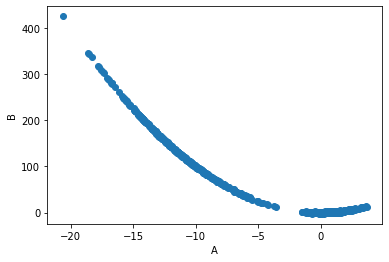

In [246]:
plt.scatter(A,B)
plt.xlabel("A")
plt.ylabel("B")

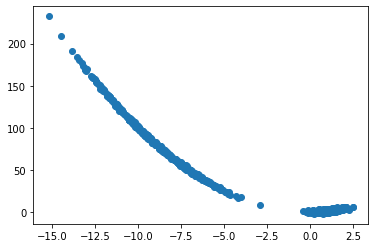

In [127]:
plt.scatter(A,B)

In [107]:
#print(dataset_names[120])
print(LA_p)
print(LB_p)
print(AB_p)

0.0
0.0
1.0


In [19]:
len(A)

1000

In [ ]:
loss_list_LB

In [ ]:
true_LB

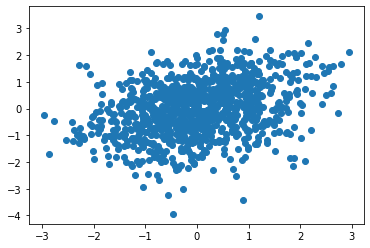

In [83]:
plt.scatter(A,B)

In [653]:
loss_list=[]

In [69]:
L_shuffle=np.random.permutation(L)

In [84]:
i=120
#A=np.array(dataset_linear[i][1])
#B=np.array(dataset_linear[i][2])
#L=np.array(dataset_linear[i][0])
opt = tf.optimizers.Nadam(1e-3)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B.T,epochs=100,  batch_size=32,verbose=0)
y_pred = mdn_PQ.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))


In [20]:
mdn_PQ.layers[0].get_weights()

[array([[ 0.25264516,  0.05248974,  0.24617057,  0.28614557,  0.08033512,
         -0.38283062, -0.28342614,  0.05896144,  0.08903217,  0.15909503,
          0.22010574,  0.04589299,  0.28408238, -0.03103847, -0.18774411],
        [ 0.48752916, -0.55488175, -0.63832676,  0.287186  ,  0.53932244,
          0.38971287, -0.4692885 , -0.22215165,  0.53320676, -0.24156927,
          0.04432451,  0.21582766,  0.47502813, -0.5153864 , -0.72298115]],
       dtype=float32),
 array([ 0.0361128 , -0.1014729 , -0.06995877, -0.08555783,  0.01940672,
         0.09437298, -0.04094372,  0.00547404,  0.00638767, -0.00167934,
         0.03539674, -0.01885239, -0.04736   , -0.04002263,  0.08709134],
       dtype=float32)]

In [85]:
alpha,mu,sigma = slice_parameter_vectors(y_pred)
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
log_likelihood = gm.log_prob(B).numpy()
loss= -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [86]:
loss

1.3660237

In [87]:
#shuffling L
L_shuffle=np.random.permutation(L)

In [88]:
#without training further , shuffle the L and see the loss 
y_pred = mdn_PQ.predict(np.concatenate([L_shuffle.reshape(-1,1),A.reshape(-1,1)],axis=1))
alpha,mu,sigma = slice_parameter_vectors(y_pred)
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
log_likelihood = gm.log_prob(B).numpy()
loss_shuffle= -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [89]:
loss_shuffle

1.387178

In [92]:
loss_shuffle-loss

0.021154284

In [673]:
loss_list.append(loss)

In [674]:
loss_list

[1.4465802, 1.6396699, 2.3458784, 1.464259, 1.7626014]

In [652]:
loss

2.6901934

In [676]:
np.average(loss_list)

1.7317978

Text(0.5, 1.0, 'Original data with added information of L')

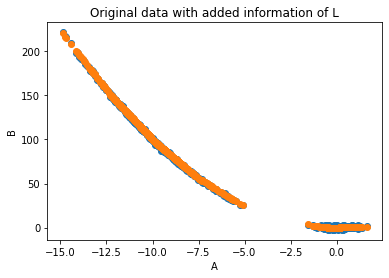

In [640]:
plt.scatter(A,B)
plt.scatter(A,y_pred[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Original data with added information of L")

In [64]:
L = np.random.binomial(1,0.5,1000)  
eps0 = np.random.normal(0,0.1,1000)
eps1 = np.random.normal(0,0.1,1000)
A = 1*L + eps0
#B=beta2+beta3*np.sin(A)+eps1
B =1*A + eps1 

In [422]:
len(A)

1000

In [677]:
loss_list_temp=[]

In [27]:
i=39
#A=np.array(dataset_linear[i][1])
#B=np.array(dataset_linear[i][2])
#L=np.array(dataset_linear[i][0])
opt = tf.optimizers.Nadam(1e-3)
mdn_PQ = MDN_module()

mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=reshapevar(A), y=B.T,epochs=100,batch_size=32,verbose=0)
y_pred_withoutL = mdn_PQ.predict(reshapevar(A))


In [28]:
mdn_PQ.layers[0].get_weights()

[array([[ 0.07883058, -0.4980739 ,  0.48454434, -0.4100085 ,  0.23665442,
          0.36611447,  0.3798871 ,  0.33531478, -0.37593538, -0.38566402,
          0.01889586,  0.67508596,  0.04911702, -0.2633836 , -0.40269122]],
       dtype=float32),
 array([-0.01121801, -0.03848534, -0.06467865, -0.19489294,  0.16336292,
        -0.04852029,  0.00821593, -0.01587688,  0.21520197,  0.07818536,
        -0.0802846 ,  0.03717825, -0.01214256, -0.04510584, -0.02797637],
       dtype=float32)]

In [34]:
alpha,mu,sigma = slice_parameter_vectors(y_pred_withoutL)
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
log_likelihood = gm.log_prob(B).numpy()
loss= -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [35]:
loss

1.4155275

In [701]:
loss_list_temp.append(loss)

In [702]:
loss_list_temp

[1.4800247, 1.6861252, 3.7701688, 1.5741543, 1.5206839]

In [703]:
np.average(loss_list_temp)

2.0062313

Text(0.5, 1.0, 'Original data without the added information L')

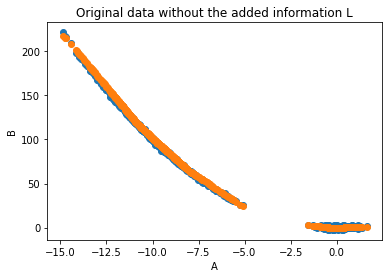

In [632]:
plt.scatter(A,B)
plt.scatter(A,y_pred_withoutL[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Original data without the added information L")


In [93]:
indices_1 = [i for i, x in enumerate(L) if x == 1]
#changed x=0 to x=-1
indices_0 = [i for i, x in enumerate(L) if x == 0]
B_dist_temp=np.zeros(len(B))
mod_indices_1=random.sample(indices_1,len(indices_1))
for i in range(len(indices_1)):
    B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

mod_indices_0=random.sample(indices_0,len(indices_0))
for i in range(len(indices_0)):
    B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]

In [94]:
B_dist_temp

array([-5.13234975e-01, -7.37097131e-01,  4.62707283e-02,  1.42566620e+00,
        1.89136450e+00, -1.56220677e+00, -1.32671738e+00, -8.04390702e-01,
        1.38214912e+00,  2.80759028e-01,  1.58006267e+00, -2.39061574e-01,
        1.01636754e-01,  1.12028522e+00,  8.16960156e-01,  3.16973560e-01,
        1.85078831e+00, -3.04449669e-01,  4.93109711e-01, -1.27928489e+00,
       -4.85793657e-01,  1.15884797e+00, -5.21339189e-01,  5.15972905e-01,
        9.42435079e-01,  2.95879036e-01, -9.72378727e-01, -6.81481149e-01,
        1.38723559e-02, -2.24347484e+00, -4.16342434e-01,  1.20513723e+00,
        4.08133482e-01, -1.10476072e+00,  1.35358128e+00,  4.02983371e-01,
       -1.31382769e+00, -4.76770803e-01, -8.66882176e-01, -8.98322616e-01,
       -2.02790785e+00,  1.21212694e-02,  9.11098363e-02, -6.65114820e-01,
        4.20181703e-01, -1.44545114e+00,  6.94201030e-01, -1.57366347e+00,
        5.79661668e-01,  6.19398097e-01,  1.18558296e+00,  1.56253319e+00,
       -1.80871876e+00,  

In [96]:
opt = tf.optimizers.Nadam(1e-3)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B_dist_temp.T,epochs=200,  batch_size=32,verbose=0)
y_pred_permL = mdn_PQ.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))


In [38]:
mdn_PQ.layers[0].get_weights()

[array([[ 0.35107043, -0.2778048 ,  0.45216545, -0.21506318, -0.25856617,
          0.21543454, -0.3420504 ,  0.6167281 , -0.16649646,  0.11847921,
          0.25845903,  0.41260982,  0.44734475, -0.03990937,  0.3319085 ],
        [ 0.23257351,  0.03083565,  0.55770504, -0.62368864, -0.25534385,
          0.50950235,  0.26258284,  0.01347695,  0.504305  , -0.31579137,
          0.00659111,  0.14038509,  0.4436975 , -0.34832567,  0.25167894]],
       dtype=float32),
 array([-0.01717891, -0.07744368,  0.14616115,  0.12111072, -0.09678373,
        -0.03346783,  0.02213036,  0.09878901, -0.06129839, -0.05929307,
        -0.01467919, -0.06514503,  0.07802954, -0.12430618, -0.04050766],
       dtype=float32)]

In [97]:
alpha,mu,sigma = slice_parameter_vectors(y_pred_permL)
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
log_likelihood = gm.log_prob(B_dist_temp).numpy()
loss_perm= -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [98]:
loss_perm

1.4299976

In [134]:
L_shuffle=np.random.permutation(L)

In [135]:
y_pred_permL = mdn_PQ.predict(np.concatenate([L_shuffle.reshape(-1,1),A.reshape(-1,1)],axis=1))
alpha,mu,sigma = slice_parameter_vectors(y_pred_permL)
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
log_likelihood = gm.log_prob(B_dist_temp).numpy()
loss_perm_shuffle= -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [136]:
loss_perm_shuffle

1.4409829

In [137]:
loss_perm_shuffle-loss_perm

0.010985374

Text(0.5, 1.0, 'Permuted data with the added information L')

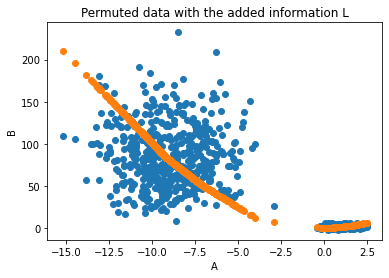

In [226]:
plt.scatter(A,B_dist_temp)
plt.scatter(A,y_pred[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Permuted data with the added information L")

In [ ]:
plt.scatter(L,B_dist_temp)

In [ ]:
y_pred[:,1]

In [57]:
opt = tf.optimizers.Nadam(1e-3)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
withoutL=mdn_PQ.fit(x=reshapevar(A), y=B_dist_temp.T,epochs=100,  batch_size=32,verbose=0)
y_pred_permwithoutL = mdn_PQ.predict(reshapevar(A))

In [89]:
mdn_PQ.layers[3].get_weights()

[array([[ 0.02184762],
        [ 0.34048617],
        [-0.5926892 ],
        [-0.53632855],
        [-0.33772627],
        [-0.20901696],
        [ 0.03389714],
        [ 0.54519737],
        [-0.21056986],
        [-0.63693786],
        [-0.46571752],
        [-0.18137042],
        [ 0.7315042 ],
        [-0.37944126],
        [-0.21867684]], dtype=float32),
 array([0.10030894], dtype=float32)]

In [59]:
alpha,mu,sigma = slice_parameter_vectors(y_pred_permwithoutL)
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
    
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
log_likelihood = gm.log_prob(B).numpy()
loss= -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [60]:
loss


1.65668

Text(0.5, 1.0, 'Permuted data without the added information')

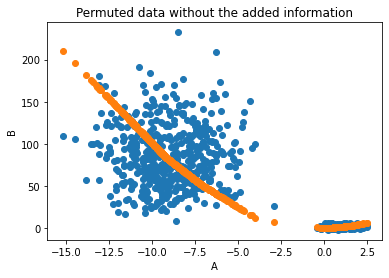

In [230]:
plt.scatter(A,B_dist_temp)
plt.scatter(A,y_pred[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Permuted data without the added information")

In [ ]:
L = np.random.binomial(1,0.5,1000)  
#eps0 = np.random.standard_normal(1000)
#eps1 = np.random.standard_normal(1000)
eps0 = np.random.normal(-2,0.5,1000)
eps1 = np.random.normal(-5,0.5,1000)
A=9*L - eps0
B=8*np.sin(A)+eps1

In [ ]:
indices_1 = [i for i, x in enumerate(L) if x == 1]
indices_0 = [i for i, x in enumerate(L) if x == 0]

In [ ]:
plt.scatter(L,A)
plt.title("L vs A")
plt.xlabel("L")
plt.ylabel("A")

In [ ]:
plt.scatter(L,B)
plt.title("L vs B")
plt.xlabel("L")
plt.ylabel("B")

In [ ]:
plt.scatter(A[indices_1],B[indices_1],label="L=1")
plt.scatter(A[indices_0],B[indices_0],label="L=0")
plt.title("A vs B")
plt.xlabel("A")
plt.ylabel("B")
plt.legend()

In [ ]:
plt.scatter(A,B)
plt.title("Simulated data")
plt.xlabel("A")
plt.ylabel("B")

In [ ]:
str(pearsonr(A,B)[0])

In [ ]:
f = open("testing_writingvalues_debugSine.txt", "w")
f.write(str(9)+" "+ str(8))
f.write("\n")
np.savetxt(f,L,newline=' ',fmt='%s')
f.write("\n")
np.savetxt(f,A,newline=' ',fmt='%s')
f.write("\n")
np.savetxt(f,B,newline=' ',fmt='%s')
f.write("\n")
f.close()
